In [1]:
%%capture
!apt install python3-dev graphviz libgraphviz-dev pkg-config
!pip install numpy scipy pandas networkx pygraphviz matplotlib

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from networkx.drawing.nx_agraph import graphviz_layout
from typing import List, Tuple

# Structural Causal Models: Matrix Form

By Alessio Zanga, Niccolò Rocchi and Fabio Stella

## Abstract

There are various types of Structural Causal Models (SCMs) with their associated functional form:

|          Type          |                 Functional Form                   |
|------------------------|---------------------------------------------------|
| General SCM            | $$X_i := f_{X_i}(Pa(X_i), U_{X_i})$$              |
| Additive Noise Model   | $$X_i := f_{X_i}(Pa(X_i)) + U_{X_i}$$             |
| Linear Gaussian Model  | $$X_i := \sum_{X_j \in Pa(X_i)} \beta_{ij} X_j + c_i + \mathcal{N}(\mu_i, \sigma_i^2)$$                                                          |

We are going to model a **Linear Gaussian** SCM, a particular version of additive models, due to its simplicity and flexibility.

Observe that, by incorporating the intercept $c_i$ into $\mu_i$, we may assume without loss of generality that $c_i = 0$. However, in the whole notebook we'll assume **zero mean** for the noises, so that the Linear Gaussian SCM takes the form:

$$
X_i := \sum_{X_j \in Pa(X_i)} \beta_{ij} X_j + \mathcal{N}(0, \sigma_i^2)
$$

## Introduction

### Systems of Linear Equations

Recall the definition of a system of linear equations:

$\begin{cases}
  a_{11} x_1 + a_{12} x_2 + \dots + a_{1n} x_n = b_1 \\
  a_{11} x_1 + a_{12} x_2 + \dots + a_{1n} x_n = b_2 \\
  \vdots \\
  a_{mn} x_1 + a_{mn} x_2 + \dots + a_{mn} x_n = b_m \\
\end{cases}$

or more concisely as:

$x_1 \begin{bmatrix}
a_{11} \\
a_{21} \\
\vdots \\
a_{m1}
\end{bmatrix} +
x_2 \begin{bmatrix}
a_{12} \\
a_{22} \\
\vdots \\
a_{m2}
\end{bmatrix} +
\dots +
x_n \begin{bmatrix}
a_{1n} \\
a_{2n} \\
\vdots \\
a_{mn}
\end{bmatrix} =
\begin{bmatrix}
b_{1} \\
b_{2} \\
\vdots \\
b_{m}
\end{bmatrix}$

which can be expressed in **matrix form** as:

$\underset{(m \times n)}{\mathbf{A}} \underset{(n \times 1)}{\mathbf{x}} = \underset{(m \times 1)}{\mathbf{b}}$

where:

* $\mathbf{A}$ is the matrix of *coefficients*,
* $\mathbf{x}$ is a vector of *unknowns*,
* $\mathbf{b}$ is a vector of *constant terms*.

In case where there is a number of equations $m$ equals to the number of unknowns $n$, we have:

$\underset{({\color{red} n} \times n)}{\mathbf{A}} \underset{(n \times 1)}{\mathbf{x}} = \underset{({\color{red} n} \times 1)}{\mathbf{b}}$

hence, $\mathbf{A}$ is a square matrix.

### Defining an SCM with Matrix Form

We are going to employ the matrix form of a system of linear equations to model a **Linear Gaussian** SCM $\mathcal{M}$.

Recall that an SCM $\mathcal{M}$ is defined by a tuple $(\mathbf{V}, \mathbf{U}, \mathbf{F})$, where:


* $\mathbf{V}$ is the set of $n$ endogenous variables,
* $\mathbf{U}$ is the set of $m$ exogenous variables,
* $\mathbf{F}$ is the set of $n$ functions, one for each $V_i$.

If $\mathbf{F}$ contains only linear functions, we can express it as a **system of linear equations**.

Moreover, in a **Linear Gaussian** SCM, the exogenous variables are independent among each other and Gaussian distributed. Moreover, each noise $\mathcal{N}(0, \sigma^2_i)$ is a linear combination of a subset $\mathbf{U}_i \subseteq \mathbf{U}$. Remember indeed that a linear combination of Gaussian distributions is still Gaussian.

During the modelling step, a first pitfall would be to map the variables in $\mathbf{V} \cup \mathbf{U}$ directly to the unknowns $\mathbf{x}$. This will result in a $\mathbf{A}$ coefficient square matrix with shape $([n+m], [n+m])$, with $|\mathbf{V}| = n$ and $|\mathbf{U}| = m$. It would result in a system of the form:

$\underset{([n + m] \times [n + m])}{\mathbf{A}} \underset{([n + m] \times 1)}{\mathbf{x}} = \underset{([n + m] \times 1)}{\mathbf{b}}$

However, we cannot observe the noises, that is the values they assume.

Therefore, we map:

* the set of endogenous variables $\mathbf{V}$ to endogneous unknowns $\mathbf{x}$ and,
* the set of exogenous variables $\mathbf{U}$ to exogenous unknowns $\mathbf{y}$.

This means to exploit the endogeneous unknowns $\mathbf{x}$, the exogenous unknowns $\mathbf{y}$ and the inherited *additive noise model* as:

$\underset{(n \times n)}{\vphantom{y}\mathbf{A}}
 \underset{(n \times 1)}{\vphantom{y}\mathbf{x}}
 {\color{red}{- \underset{(n \times m)}{\vphantom{y}\pmb{\Gamma}}
 \underset{(m \times 1)}{\mathbf{y}}}} =
 \underset{({\color{red} n} \times 1)}{\vphantom{y}\mathbf{b}}$

The meaning of the minus ($-$) sign will be clear in a moment.

Please, notice how the shape of $\mathbf{b}$ is only $(n \times 1)$ and not $([n + m] \times 1)$, since we cannot observe directly the actual value of the noise terms $\mathbf{y}$, but only their effect on $\mathbf{x}$, which is hidden behind the sum operation.

For example, consider the following SCM $\mathcal{M}$:

$\begin{cases}
  x_1 := 2x_2 + y_1 \\
  x_2 := 3x_3 + y_2 \\
  x_3 := 2y_2 + y_3
\end{cases}$

Then we can express the SCM in the language of a system of linear equations:

$\begin{cases}
  x_1 - 2x_2 - y_1 = 0 \\
  x_2 - 3x_3 - y_2 = 0 \\
  x_3 - 2y_2 \, - y_3 = 0
\end{cases}$

which is explicitly:

$\begin{cases}
  {\color{red} 1}x_1 - 2x_2 \,{\color{red} {+ \; 0x_3 - 1}}y_1 \, {\color{red} {+ \; 0y_2 + 0y_3}} = 0 \\
  {\color{red} {0x_1 + 1}}x_2 - 3x_3 \, {\color{red} {+ \; 0y_1 - 1}}y_2 \;{\color{red} {+ \, 0y_3}} = 0 \\
  {\color{red} {0x_1 + 0x_2 + 1}}x_3 \, {\color{red} {+ \; 0y_1}} - 2y_2 \; {\color{red} {- \, 1}}y_3 = 0
\end{cases}$

It has the following matrix form:

In [3]:
# Coefficient matrix for the endogenous variables.
A = np.array([
    [1., 2., 0.],
    [0., 1., 3.],
    [0., 0., 1.],
])
# Endogenous variables.
x = ["$x_1$", "$x_2$", "$x_3$"]
# Coefficient matrix for the exogenous variables.
C = np.array([
    [1., 0., 0.],
    [0., 1., 0.],
    [0., 2., 1.],
])
# Exogenous variables.
y = ["$y_1$", "$y_2$", "$y_3$"]
# Constant terms (zero because of zero mean of noises)
b = [0, 0, 0]

As you might have noticed, the diagonal of $\mathbf{A}$ is always $\mathbf{1}$, therefore, to make it explicit and to differentiate it from the standard notation used in graphs, we rewrite both $\mathbf{A}$ as:

${\color{red}{
    \underset{(n \times n)}{\vphantom{y}(\mathbf{I} - \mathbf{B})}
 }}
 \underset{(n \times 1)}{\vphantom{y}\mathbf{x}} -
 \underset{(n \times m)}{\vphantom{y}\pmb{\Gamma}}
 \underset{(m \times 1)}{\mathbf{y}} =
\underset{(n \times 1)}{\vphantom{y}\mathbf{b}}$

where $\mathbf{I}$ is the identity matrix.

Rearranging the terms, the SCM form becomes more visible:

${\color{red}{
    \underset{(n \times n)}{\vphantom{y}\mathbf{I}}
 }}
 \underset{(n \times 1)}{\vphantom{y}\mathbf{x}} =
 {\color{red}{
    \underset{(n \times n)}{\vphantom{y}\mathbf{B}}
 }}
 \underset{(n \times 1)}{\vphantom{y}\mathbf{x}} +
 \underset{(n \times m)}{\vphantom{y}\pmb{\Gamma}}
 \underset{(m \times 1)}{\mathbf{y}} +
\underset{(n \times 1)}{\vphantom{y}\mathbf{b}}$

In [4]:
# Coefficient matrix for endogenous variables.
B = np.array([
    [0., 2., 0.],
    [0., 0., 3.],
    [0., 0., 0.],
])
# Identity matrix with same shape as endogenous coefficient matrix.
I = np.eye(*B.shape)
# Coefficient matrix for exogenous variables.
C = np.array([
    [1., 0., 0.],
    [0., 1., 0.],
    [0., 2., 1.],
])

### Expliciting the underlying Causal Graph

Following the causal edge assumption, $\mathbf{V}$ and $\mathbf{U}$ are vertices of a causal graph $\mathcal{G}$ induced by $\mathbf{F}$ :

$$
X_i := \sum_{X_j \in Pa(\mathcal{G}, X_i)} \beta_{ij} X_j + \mathcal{N}(0, \sigma_i^2), \quad \forall X_i \in \mathbf{V}
$$

A possible representation of directed graph $\mathcal{G}$ is by means of a squared *binary* adjacency matrix $\mathbf{A}$ :

$\mathbf{A}[i, j] =
a_{ij} =
\begin{cases}
  1 & \text{if } (X_i \rightarrow X_j) \in \mathbf{E}, \\
  0 & \text{otherwise.}
\end{cases}$

We can laverage the assumptions on the exogenous variables to build the adjacency matrix $\mathbf{A}$, specifically:

1. An endogenous variable cannot be parent of an exogenous variable, i.e. $(V \rightarrow U) \notin \mathbf{E}, \, \forall \, (V, U) \in \mathbf{V} \times \mathbf{U}$,
2. The exogenous variables are independent of each other, i.e. $(U_i \rightarrow U_j) \notin \mathbf{E}, \, \forall \, (U_i, U_j) \in \mathbf{U} \times \mathbf{U}$.

Hence, the real-valued adjacency matrix $\mathbf{W}$ is a block matrix of the form:

$\mathbf{W} = %
\left[
\begin{array}{c|c}
  \mathbf{B} & \pmb{\Gamma} \\ \hline
  \mathbf{0} & \mathbf{0} \\
\end{array}
\right]^T
= %
\left[
\begin{array}{c|c}
  \mathbf{B}^T & \mathbf{0} \\ \hline
  \pmb{\Gamma}^T & \mathbf{0} \\
\end{array}
\right]$

To obtain the binary adjacency matrix $\mathbf{A}$ we just map the previous real-valued matrix to a boolean matrix, hence by imposing $\mathbf{W} \neq 0$, and converting boolean values to $\{0, 1\}$.

Notice also we have already dismissed the notation $\mathbf{A}$ to indicate $\mathbf{I} - \mathbf{B}$. Here, $\mathbf{A}$ indicates the graph adjacency matrix, included the noise terms.

For example:

In [5]:
# Get the variables sizes.
n = len(x)
m = len(y)
# Compute the adjacency matrix.
W = np.vstack([B.T, C.T])
W = np.hstack([W, np.zeros((n + m, m))])
A = (W != 0)

print(A)

[[False False False False False False]
 [ True False False False False False]
 [False  True False False False False]
 [ True False False False False False]
 [False  True  True False False False]
 [False False  True False False False]]


We can now build the causal graph $\mathcal{G}$ given the adjacency matrix $\mathbf{A}$ :

In [6]:
def graph_from_matrix(x: List[str], y: List[str], A: np.array) -> nx.DiGraph:
    # Compute the directed graph given the adjacency matrix.
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)
    # Set nodes labels.
    G = nx.relabel_nodes(G, dict(zip(G.nodes, x + y)))
    # Set exogenous and endogenous variables as attributes.
    G.graph["V"] = set(x)
    G.graph["U"] = set(y)

    return G

Let's define a plot style:

In [7]:
def draw(G):
    plt.figure()
    pos = graphviz_layout(G, prog = "dot")
    for v in G.nodes():
        nx.draw_networkx_nodes(
            G,
            pos = pos,
            nodelist = [v],
            node_color = "white",
            edgecolors = "black" if v in G.graph["V"] else "gray",
            node_size = 500,
            node_shape = "o",
        )
        nx.draw_networkx_labels(
            G,
            pos = pos,
            font_size = 15,
        )
    for (u, v) in G.edges():
        nx.draw_networkx_edges(
            G,
            pos = pos,
            edgelist = [(u, v)],
            edge_color = "black",
            style = "solid" if u not in G.graph["U"] else "dashed",
            width = 1.0,
        )
    weights = nx.get_edge_attributes(G, "weight")
    if type(list(weights.values())[0]) != bool:
        nx.draw_networkx_edge_labels(
            G,
            pos = pos,
            edge_labels = weights,
            font_color = "red",
            font_size = 13,
        )

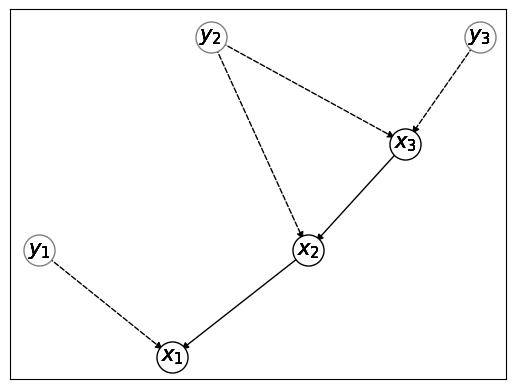

In [8]:
# Build the causal graph from adjacency matrix.
G = graph_from_matrix(x, y, A)
# Plot the causal graph.
draw(G)

If we want to make the coefficient explicit, we can build a **weighted** directed graph:

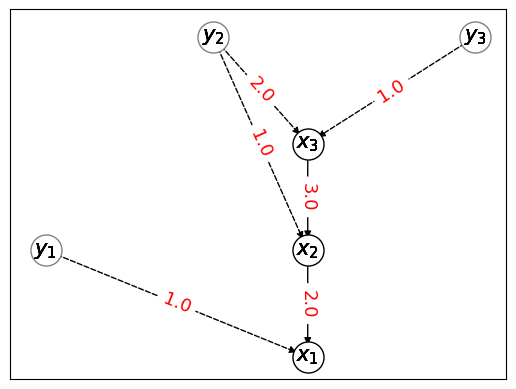

In [9]:
# Build the causal graph from adjacency matrix.
G = graph_from_matrix(x, y, W)
# Plot the causal graph.
draw(G)

## Implementation

### Sampling from an SCM

Suppose we are given a SCM $\mathcal{M}$. How do we sample a data set $\mathbf{D}$ from $\mathcal{M}$ ?

Keep in mind we are assuming each noise to have a $0$ mean. Since we are considering a linear Gaussian SCM $\mathcal{M}$, sampling the data set $\mathbf{B}$ from $\mathcal{M}$ is equivalent to sampling from a **multivariate normal distribution** $\mathcal{N}(0, \pmb{\Sigma})$, where the variables in $\mathcal{N}$ are $\mathbf{V} \cup \mathbf{U}$, and $\pmb{\Sigma}$ is their covariance matrix.

With these assumptions, the covariance matrix over $\mathbf{V} \cup \mathbf{U}$ is defined as:

$\pmb{\Sigma} = (\mathbf{I} - \mathbf{B})^{-1}
\pmb{\Psi}
\left((\mathbf{I} - \mathbf{B})^{-1}\right)^{T}$

where $\pmb{\Psi} = \pmb{\Gamma} + \pmb{\Gamma}^T - \mathbf{I}\cdot\pmb{\Gamma}$, i.e. the symmetric of $\pmb{\Gamma}$.

Hence, we can define a sampling procedure by leveraging $\mathbf{B}$ and $\pmb{\Gamma}$:

In [10]:
def sample(M: Tuple, size: int = int(1e6), seed: int = 31) -> pd.DataFrame:
    # Explicit matrix form.
    (x, y, B, C) = M
    # Allocate the identity matrix.
    I = np.eye(*B.shape)
    # Compute the scale.
    IB = np.linalg.inv(I - B)
    # Compute the actual noise distribution.
    Psi = C + C.T - np.eye(*C.shape) * C
    # Compute the actual data distribution.
    Sigma = IB @ Psi @ IB.T
    # Set the seed for reproducibility.
    np.random.seed(seed)
    # Sample from a multivariate normal distribution.
    D = np.random.multivariate_normal([0] * B.shape[0], Sigma, size)
    # Compute the data frame.
    D = pd.DataFrame(data = D, columns = x)

    return D

We can now sample from a model:

In [11]:
# Specify the model.
M = (x, y, B, C)
# Sample the data.
D = sample(M)
# Compute the summary statistics.
D.describe()

<ipython-input-10-8dc4accb5319>:15: RuntimeWarning: covariance is not positive-semidefinite.
  D = np.random.multivariate_normal([0] * B.shape[0], Sigma, size)


,$x_1$,$x_2$,$x_3$
count,1000000.000000,1000000.000000,1000000.000000
mean,0.009500,0.004184,0.001467
std,9.430900,4.689909,1.120898
min,-43.815576,-21.966539,-5.664769
25%,-6.355846,-3.160213,-0.754233
50%,0.003506,0.002797,0.000623
75%,6.379702,3.170067,0.758427
max,46.216736,22.477628,5.369341


### Fitting an SCM

Suppose we are given a data set $\mathbf{D}$ and a causal graph $\mathcal{G}$. How do we recover the associated SCM $\mathcal{M}$ given $\mathbf{D}$ and $\mathcal{G}$ ?

Recall that the underlying system of SCM $\mathcal{M}$ was:

$\begin{cases}
  {\color{red} 1}x_1 - 2x_2 \,{\color{red} {+ \; 0x_3 - 1}}y_1 \, {\color{red} {+ \; 0y_2 + 0y_3}} = b_1 \\
  {\color{red} {0x_1 + 1}}x_2 - 3x_3 \, {\color{red} {+ \; 0y_1 - 1}}y_2 \;{\color{red} {+ \, 0y_3}} = b_2 \\
  {\color{red} {0x_1 + 0x_2 + 1}}x_3 \, {\color{red} {+ \; 0y_1}} - 2y_2 \; {\color{red} {- \, 1}}y_3 = b_3
\end{cases}$

Recovering the SCM $\mathcal{M}$ would require to estimate the unknown parameters ${\color{blue} {\beta_{ij}}}$ and ${\color{blue} {\gamma_{ij}}}$ :

$\begin{cases}
  {\color{blue} {\beta_{11}}}x_1 + {\color{blue} {\beta_{12}}}x_2 + {\color{blue} {\beta_{13}}}x_3 + {\color{blue} {\gamma_{11}}}y_1 + {\color{blue} {\gamma_{12}}}y_2 + {\color{blue} {\gamma_{13}}}y_3 = b_1 \\
  {\color{blue} {\beta_{21}}}x_1 + {\color{blue} {\beta_{22}}}x_2 + {\color{blue} {\beta_{23}}}x_3 + {\color{blue} {\gamma_{21}}}y_1 + {\color{blue} {\gamma_{22}}}y_2 + {\color{blue} {\gamma_{23}}}y_3 = b_2 \\
  {\color{blue} {\beta_{31}}}x_1 + {\color{blue} {\beta_{32}}}x_2 + {\color{blue} {\beta_{33}}}x_3 + {\color{blue} {\gamma_{31}}}y_1 + {\color{blue} {\gamma_{32}}}y_2 + {\color{blue} {\gamma_{33}}}y_3 = b_3 \\
\end{cases}$

more concisely:

$(\mathbf{I} - \mathbf{B}) =
\begin{bmatrix}
  {\color{blue} {\beta_{11}}} & {\color{blue} {\beta_{12}}} & {\color{blue} {\beta_{13}}} \\
  {\color{blue} {\beta_{21}}} & {\color{blue} {\beta_{22}}} & {\color{blue} {\beta_{23}}} \\
  {\color{blue} {\beta_{31}}} & {\color{blue} {\beta_{32}}} & {\color{blue} {\beta_{33}}}
\end{bmatrix},
~ - \pmb{\Gamma} =
\begin{bmatrix}
  {\color{blue} {\gamma_{11}}} & {\color{blue} {\gamma_{12}}} & {\color{blue} {\gamma_{13}}} \\
  {\color{blue} {\gamma_{21}}} & {\color{blue} {\gamma_{22}}} & {\color{blue} {\gamma_{23}}} \\
  {\color{blue} {\gamma_{31}}} & {\color{blue} {\gamma_{32}}} & {\color{blue} {\gamma_{33}}}
\end{bmatrix}$

If we constrain $\mathbf{B}$ and $\pmb{\Gamma}$ to follow the structure implied by the graph $\mathcal{G}$, then we have:

In [12]:
# Compute the adjacency matrix.
A = nx.adjacency_matrix(G).todense().astype(bool).astype(float)
# Get the number of endogenous and exogenous variables.
n = len(G.graph["V"])
m = len(G.graph["U"])
# Extract the direct effects of endogenous variables, i.e. (Beta != 0).
B_0 = A[0:n, 0:n].T.copy()
# Extract the variances-covariances of exogenous variables, i.e. (Gamma != 0).
C_0 = A[n:, 0:n].T.copy()

# Compute non-zero entries of Beta_0.
k = int(np.sum(B_0))

print(B_0)
print(C_0)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 1.]]


Hence, the only unknown parameters are:

$(\mathbf{I} - \mathbf{B}) =
\begin{bmatrix}
  1 & {\color{blue} {\beta_{12}}} & 0 \\
  0 & 1 & {\color{blue} {\beta_{23}}} \\
  0 & 0 & 1
\end{bmatrix},
~ - \pmb{\Gamma} =
\begin{bmatrix}
  {\color{blue} {\gamma_{11}}} & 0 & 0 \\
  0 & {\color{blue} {\gamma_{22}}} & 0 \\
  0 & {\color{blue} {\gamma_{32}}} & {\color{blue} {\gamma_{33}}}
\end{bmatrix}$

which can be represented as a **row vector** of unknown parameters:

$\theta =
\left[
\begin{array}{cc|cccc}
  {\color{blue} {\beta_{12}}} &
  {\color{blue} {\beta_{23}}} &
  {\color{blue} {\gamma_{11}}} &
  {\color{blue} {\gamma_{22}}} &
  {\color{blue} {\gamma_{32}}} &
  {\color{blue} {\gamma_{33}}}
\end{array}
\right]$

Define the **model implied** covariance matrix $\pmb{\Sigma}(\hat{\theta})$ given the estimated parameters $\hat{\theta}$:

$\pmb{\Sigma}(\hat{\theta}) = (\mathbf{I} - \mathbf{B}(-\hat{\theta}))^{-1}
\pmb{\Psi}(-\hat{\theta})
\left((\mathbf{I} - \mathbf{B}(-\hat{\theta}))^{-1}\right)^{T}$

Computing $\mathbf{B}(-\hat{\theta})$ and $\pmb{\Gamma}(-\hat{\theta})$ only requires to **assign** $-\hat{\theta}$ to non-zero entries of such matrices.

Let's define an assignment function:

In [13]:
def assign(X: np.ndarray, x: np.ndarray) -> np.ndarray:
    # Make a copy of X.
    X = X.copy()
    # Get non-zero indices.
    i = np.ravel(X).nonzero()[0]
    # Assign non-zero values.
    X.flat[i] = x

    return X

For example:

In [14]:
# Solution for the above system.
theta = np.array([-2., -3., -1., -1., -2., -1.])

print(assign(B_0, np.negative(theta[:k])))
print(assign(C_0, np.negative(theta[k:])))

[[0. 2. 0.]
 [0. 0. 3.]
 [0. 0. 0.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 2. 1.]]


Compute the covariance matrix $\pmb{\Sigma}(\hat{\theta})$ given the estimated parameters $\hat{\theta}$:

In [15]:
def Sigma(theta: np.ndarray) -> np.ndarray:
    # Assign the negation of estimated parameters theta to B.
    B = assign(B_0, np.negative(theta[:k]))
    # Allocate the identity matrix.
    I = np.eye(*B.shape)
    # Compute the scale.
    IB = np.linalg.inv(I - B)

    # Assign the negation of estimated parameters theta to Gamma.
    C = assign(C_0, np.negative(theta[k:]))
    # Compute the variances and covariances of the exogenous variables.
    Psi = C + C.T - np.eye(*C.shape) * C

    # Enforce positivity.
    np.fill_diagonal(Psi, np.exp(np.diagonal(Psi)))

    # Compute the *model implied* covariance matrix.
    return IB @ Psi @ IB.T

In [16]:
# Print the model-implied true covariance matrix
Sigma(theta)

array([[159.44955497,  78.36563657,  20.30969097],
       [ 78.36563657,  39.18281828,  10.15484549],
       [ 20.30969097,  10.15484549,   2.71828183]])

Compute the observed covariance matrix $\mathbf{S}$ given the data set $\mathbf{D}$:

In [17]:
# Compute the sample covariance matrix.
S = np.cov(D.to_numpy().T)

print(S)

[[88.94187022 43.97595814  9.98538505]
 [43.97595814 21.99524571  4.95808053]
 [ 9.98538505  4.95808053  1.25641161]]


Define a *loss function* between the observed covariance matrix $\mathbf{S}$ and the model implied covariance matrix $\pmb{\Sigma}(\hat{\theta})$:

$\mathcal{L}(\mathbf{S}, \pmb{\Sigma}(\hat{\theta})) = tr(\mathbf{S}\pmb{\Sigma}(\hat{\theta})^{-1}) + \ln|\pmb{\Sigma}(\hat{\theta})| - \ln|\mathbf{S}| - n$

In [18]:
# Define loss function.
def loss(theta: np.ndarray) -> float:
    # Compute Sigma given theta parameters.
    Sigma_t = Sigma(theta)
    # Evaluate loss function.
    return np.trace(S @ np.linalg.inv(Sigma_t)) + np.log(np.linalg.det(Sigma_t)) - np.log(np.linalg.det(S)) - n

Minimize the loss function $\mathcal{L}$ w.r.t. $\mathbf{S}$ and $\pmb{\Sigma}(\hat{\theta})$:

In [19]:
# Initialize first solution.
np.random.seed(31)
theta_0 = np.random.rand(int(np.sum(A)))
# Minimize loss function.
optimal = minimize(loss, theta_0, method = "CG", tol = 1e-6)
# Get the solution *x*
theta_hat = optimal.x
# Assign estimated coefficients theta_hat to Beta and Gamma.
B = assign(B_0, np.negative(theta_hat[:k]))
C = assign(C_0, np.negative(theta_hat[k:]))

print(B)
print(C)

[[0.         1.99933925 0.        ]
 [0.         0.         2.35389296]
 [0.         0.         0.        ]]
[[0.0188324  0.         0.        ]
 [0.         1.72547889 0.        ]
 [0.         2.00062492 0.22826104]]


### Estimating with an SCM

Suppose we are given a SCM $\mathcal{M}$ and a causal estimand $\tau$. How do we estimate $\tau$ from $\mathcal{M}$ ?

In a linear SCM, the total effect $\tau = \mathbb{E}\left[ Y(1) - Y(0) \right]$ is computed as the sum of the effect of each directed path $\pi$ from $X$ to $Y$, where the effect of each directed path $\pi$ is obtained by multiplying each direct effect along such path:

$$
\tau = \mathbb{E}\left[ Y(1) - Y(0) \right] = \sum_{\pi \in \Pi(X, Y)}\prod_{(Z_i \rightarrow Z_j) \in \pi} \mathbf{B}[Z_i, Z_j]
$$

hence, by exploiting the weighted graph representation:

In [20]:
def total_effect(G: nx.DiGraph, X: str, Y: str) -> float:
    # Initialize the total effect.
    tau = 0
    # Iterate over the paths.
    for path in sorted(nx.all_simple_edge_paths(G, X, Y)):
        # Initialize the path effect.
        tau_pi = 1
        # Iterate over the edges.
        for (i, j) in path:
            # Reduce the path effect.
            tau_pi = tau_pi * G[i][j]["weight"]
        # Accumulate the effect.
        tau = tau + tau_pi
    # Return the total effect.
    return tau

For example, compute the effect from $X_1$ to $X_3$:

In [21]:
total_effect(G, "$x_3$", "$x_1$")

6.0